In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

from prophet import Prophet

/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('transaction_data_with_seasonality_100k.csv', parse_dates=['transaction_date'])

In [3]:
item_id = 1

In [4]:
data.set_index('transaction_date', inplace=True)

In [5]:
weekly_data = data.groupby(['item_id']).resample('W').agg({
    'quantity': 'sum',
    'price': 'mean'
}).reset_index()

In [8]:
item_data = weekly_data[(weekly_data['item_id'] == item_id)] 
item_data.set_index('transaction_date', inplace=True) 


<Axes: xlabel='transaction_date'>

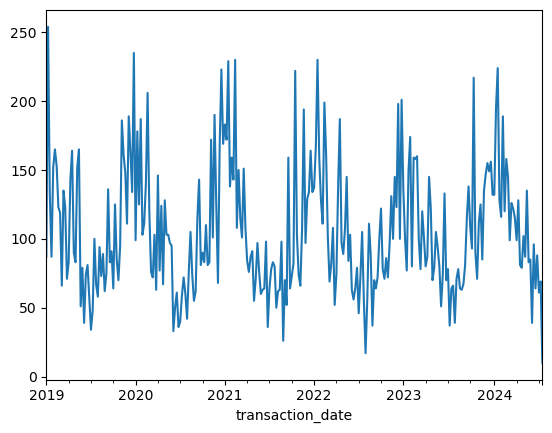

In [9]:
item_data['quantity'].plot()

In [10]:
# Split the data into train and test sets
train_size = int(len(item_data) * 0.8) 
train_data, test_data = item_data[:train_size], item_data[train_size:] 


In [11]:
model = SARIMAX(train_data['quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))  # Annual seasonality
model_fit = model.fit(disp=False) 


/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/khair1212/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [13]:
# Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data['quantity'], forecast)
rmse = np.sqrt(mse)
print(f'RMSE (Weekly): {rmse}')

RMSE (Weekly): 32.70170001373095


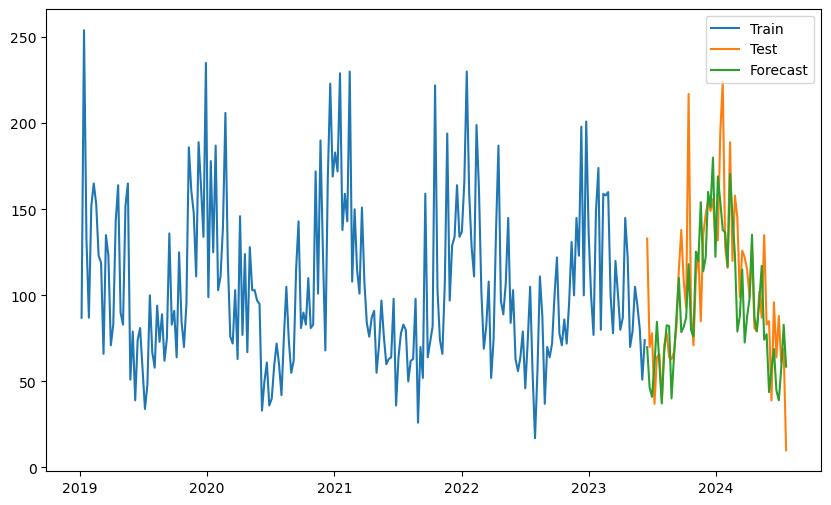

In [14]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['quantity'], label='Train')
plt.plot(test_data.index, test_data['quantity'], label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.legend()
plt.show()

# Prophet

In [15]:
item_data.head()

,item_id,quantity,price
transaction_date,,,
2019-01-06,1,87,26.974393
2019-01-13,1,254,26.450201
2019-01-20,1,133,31.539788
2019-01-27,1,87,21.265302
2019-02-03,1,152,29.766907


In [16]:
item_data_prophet = item_data.reset_index()[['transaction_date', 'quantity']].rename(columns={'transaction_date': 'ds', 'quantity': 'y'})


In [17]:
train_size = int(len(item_data_prophet) * 0.8)
train_data, test_data = item_data_prophet[:train_size], item_data_prophet[train_size:]


In [21]:
model = Prophet(yearly_seasonality=True)
model.fit(train_data)

21:25:15 - cmdstanpy - INFO - Chain [1] start processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Make future dataframe and forecast
future = model.make_future_dataframe(periods=len(test_data), freq='M')
forecast = model.predict(future)

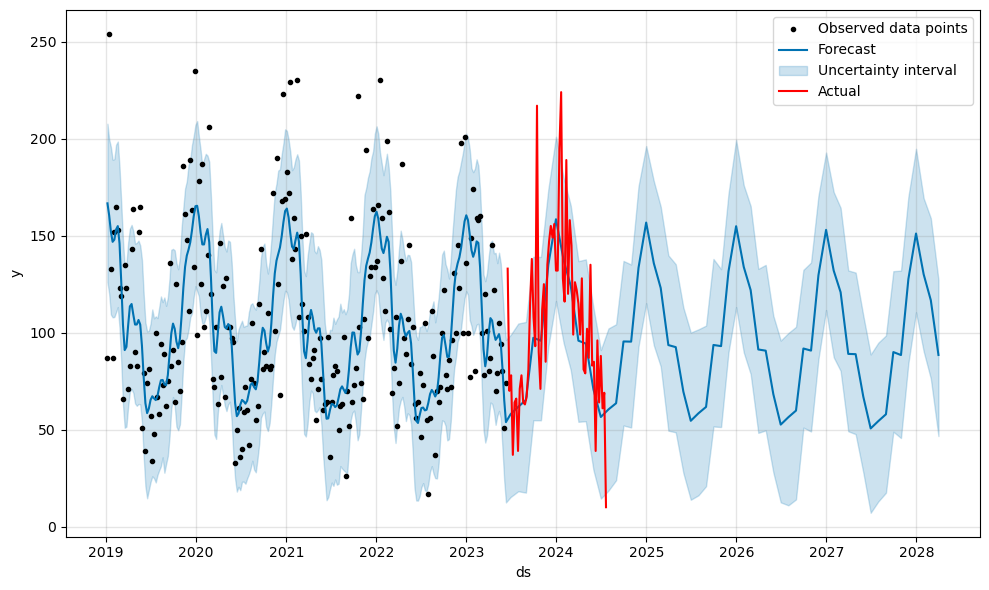

In [23]:
# Plot the forecast
fig = model.plot(forecast)
plt.plot(test_data['ds'], test_data['y'], 'r', label='Actual')
plt.legend()
plt.show()

# XGBoost 